# Ibis OmnisciDB UDF implementation prototype

In [1]:
from datetime import datetime, date
import types
from typing import Callable, List, Optional, Union

import ibis
from ibis.expr import datatypes as dt
from ibis.expr import operations as ops
from ibis.expr import types as ir
from ibis.udf import vectorized

import numpy as np
import pandas as pd
import rbc
# local
from settings import conf
from utils import cursor2df
from gen_data import salary_date, salary_date_schema

In [2]:
omni_ibis = ibis.omniscidb.connect(**conf['omniscidb'])

In [3]:
omni_ibis.list_tables()

['diamonds',
 'batting',
 'awards_players',
 'functional_alltypes',
 'geo',
 'mytable',
 'logs']

In [4]:
# ibis.omniscidb bug workaround:
import sys
sys.modules['ibis.omniscidb.operations']._sql_type_names['float32'] = 'float'

In [5]:
t = omni_ibis.table('functional_alltypes')

## Ibis OmniSciDB UDF Examples

### UDF Elementwise Example 

In [6]:
@omni_ibis.udf.elementwise(input_type=[dt.double, dt.double], output_type=dt.double)
def my_add_func(left, right):
    return left + right

/home/xmn/miniconda3/envs/ibis-nb/lib/python3.7/site-packages/rbc_project-0.2.2-py3.7.egg/rbc/omniscidb.py:364: UserWarning: 
  thrift type map: add new member TExtArgumentType.ArrayBool
  thrift type map: update TExtArgumentType.ArrayDouble to 20 (was 19)
  thrift type map: update TExtArgumentType.ArrayFloat to 19 (was 18)
  thrift type map: update TExtArgumentType.ArrayInt16 to 16 (was 15)
  thrift type map: update TExtArgumentType.ArrayInt32 to 17 (was 16)
  thrift type map: update TExtArgumentType.ArrayInt64 to 18 (was 17)
  thrift type map: update TExtArgumentType.ArrayInt8 to 15 (was 14)
  thrift type map: update TExtArgumentType.Bool to 14 (was 13)
  thrift type map: update TExtArgumentType.Cursor to 24 (was 21)
  thrift type map: add new member TExtArgumentType.GeoLineString
  thrift type map: add new member TExtArgumentType.GeoMultiPolygon
  thrift type map: update TExtArgumentType.GeoPoint to 22 (was 20)
  thrift type map: add new member TExtArgumentType.GeoPolygon
  thrift t

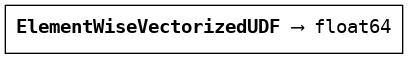

In [7]:

expr = my_add_func(t.float_col, t.float_col)
expr

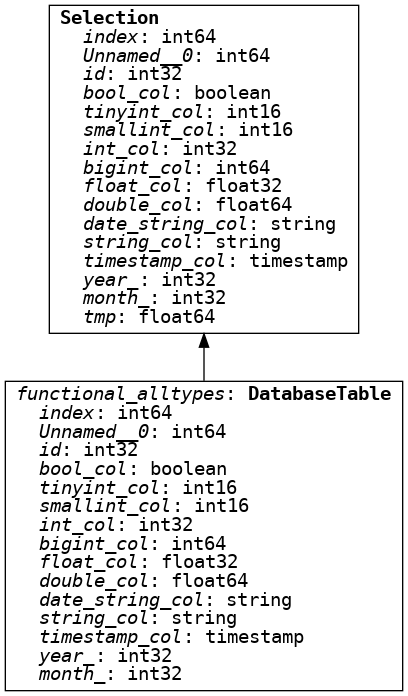

In [8]:
t[t, expr.name('tmp')]

In [9]:
assert isinstance(expr, ir.ColumnExpr)
assert isinstance(expr, ir.NumericColumn)
assert isinstance(expr, ir.FloatingColumn)
print(omni_ibis.compile(expr))

result = expr.execute()

df = t.execute()
expected = df.float_col + df.float_col

pd.testing.assert_series_equal(result, expected, check_dtype=False, check_names=False)

SELECT my_add_func("float_col", "float_col") AS tmp
FROM functional_alltypes


#### Reusing Existent Elementwise UDF

In [10]:
f = omni_ibis.udf.elementwise(
    name='my_add_func', input_type=[dt.double, dt.double], output_type=dt.double
)
print(f(t.float_col, t.float_col).compile())

SELECT my_add_func("float_col", "float_col") AS tmp
FROM functional_alltypes


#### Defining a combination of input and output for the UDF

In [11]:
@omni_ibis.udf.elementwise(input_type=[dt.int64, dt.int64], output_type=dt.int64)
@omni_ibis.udf.elementwise(input_type=[dt.double, dt.double], output_type=dt.double)
def my_add_func_int_float(left, right):
    return left + right

In [12]:
print(my_add_func_int_float(t.float_col, t.float_col).compile())
print(my_add_func_int_float(t.int_col, t.int_col).compile())

SELECT my_add_func_int_float("float_col", "float_col") AS tmp
FROM functional_alltypes
SELECT my_add_func_int_float("int_col", "int_col") AS tmp
FROM functional_alltypes


### Using literals

In [13]:
t[t.index, ibis.literal(None).name('tmp')].compile()

'SELECT "index", NULL AS tmp\nFROM functional_alltypes'

In [14]:
print(my_add_func_int_float(t.float_col, None).compile())

SELECT my_add_func_int_float("float_col", NULL) AS tmp
FROM functional_alltypes
